# New ts_gen

In [1]:
import torch
torch.cuda.empty_cache()

In [1]:
from utils.meta_eval import TSGenArgs, save_d, create_ds_dict, plot_ds
from experiments.meta_eval.me import experiment

args = TSGenArgs()
args.n_epochs = 1
args.test_interval = 1
# args.remove_existing_data = True
all_test_res = experiment(args)

Starting training...
100%|██████████| 843/843 [00:35<00:00, 23.98it/s]
Epoch 1: Training Loss 0.18155349867590995
106it [00:01, 61.68it/s]
Epoch 1: Test Loss 0.20933839089309128
Best Test Loss 0.20933839089309128 on Epoch 1


In [2]:
# from experiments.exp_utils import plot_tt_loss
# plot_tt_loss('log/21Aug04_0740AM/train.log')

# save d
file_name = '5.npy'
d_folder = 'experiments//meta_eval/d_inits/'
save_d(file_name, all_test_res, d_folder)

/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

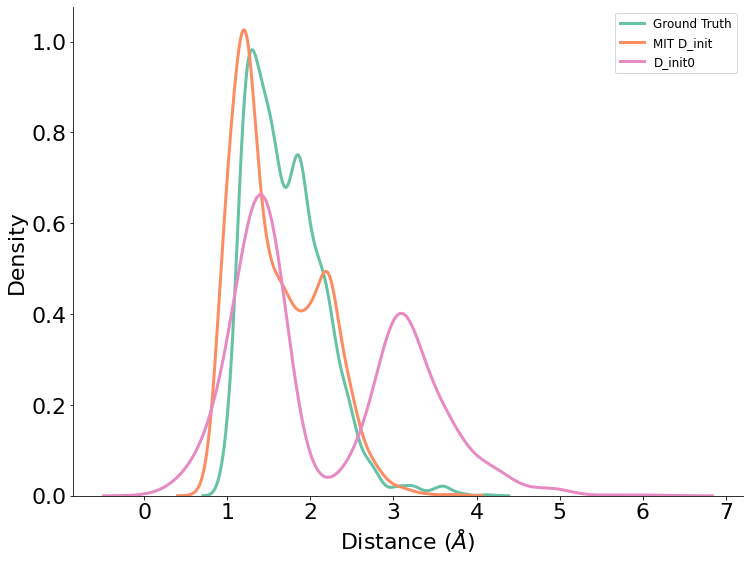

In [5]:
# create ds_dict and plot d_inits
mols_folder = 'data/raw/'
d_folder = 'experiments/meta_eval/d_inits/'
d_plot_name = None
d_files = ['5.npy'] # b/d/n=standard; e=5, h=32
ds_not_to_print = ['lin_approx']
ds_dict = create_ds_dict(d_files, d_folder, mols_folder)
plot_ds(ds_dict, ds_not_to_print, d_plot_name)

In [36]:
# TODO: add function for this: take in i and print mine, MIT, GT

def print_one_d_init(i, my_d, mit_d):
    np.set_printoptions(precision = 3, threshold = 5, edgeitems = 5, suppress = True)
    num_atoms = test_ts[i].GetNumAtoms()
    print("Mine: \n", my_d[i][0:num_atoms, 0:num_atoms])
    print("MIT: \n", mit_d[i][0:num_atoms, 0:num_atoms])
    print("GT: \n", Chem.Get3DDistanceMatrix(test_ts[i]))



print(D_init.shape, D_init1.shape)
np.set_printoptions(precision = 3, threshold = 5, edgeitems = 5, suppress = True)
i = 10
num_atoms = test_ts[i].GetNumAtoms()
print("MIT: \n", D_init[i][0:num_atoms, 0:num_atoms])
print("Mine: \n", D_init1[i][0:num_atoms, 0:num_atoms])
print("GT: \n", Chem.Get3DDistanceMatrix(test_ts[i]))

(842, 21, 21) (842, 21, 21)
Mine: 
 [[ 0.01   1.927  6.569 10.64   6.283 ...  0.925  5.99  11.117  7.605
  17.858]
 [ 1.927  0.01   2.395  4.42   2.063 ...  3.684  2.518  5.115  5.006
   8.857]
 [ 6.569  2.395  0.01   2.264  4.064 ...  9.973  7.831  1.2    1.198
   5.041]
 [10.64   4.42   2.264  0.01   1.828 ... 15.898  6.923  4.686  4.685
   1.032]
 [ 6.283  2.063  4.064  1.828  0.01  ...  9.977  2.084  7.698  7.739
   4.341]
 ...
 [ 0.925  3.684  9.973 15.898  9.977 ...  0.01   7.137 13.724 11.842
  23.922]
 [ 5.99   2.518  7.831  6.923  2.084 ...  7.137  0.01  10.676 13.604
  10.21 ]
 [11.117  5.115  1.2    4.686  7.698 ... 13.724 10.676  0.01   3.248
   6.337]
 [ 7.605  5.006  1.198  4.685  7.739 ... 11.842 13.604  3.248  0.01
   8.529]
 [17.858  8.857  5.041  1.032  4.341 ... 23.922 10.21   6.337  8.529
   0.01 ]]
GT: 
 [[0.    1.385 2.561 3.26  2.505 ... 0.957 2.445 3.333 2.756 4.225]
 [1.385 0.    1.544 2.1   1.433 ... 1.917 1.584 2.259 2.235 2.974]
 [2.561 1.544 0.    1.501 2.0

## Ensemble

Average all produced $D_{inits}s$ then plot.

In [83]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['mit'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

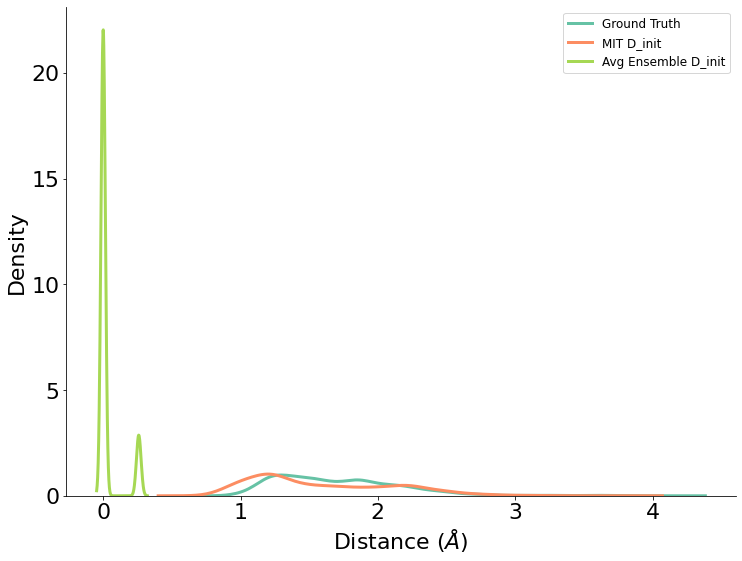

In [84]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 